Motivation slide: This project is a geotemporal exploration of ocean salinity and acidity. Three global locations were used; The Aegean Sea between Greece and Turkey; Portsmouth Harbor, where the coasts of Maine and New Hampshire meet; and finally, a stretch of ocean several hundred miles South of South Africa.  Research ships were used to gather chemical and meteorological data from the locations.  All data comes from the repositories of the National Oceanic and Atmospheric Administration.  The specific data sets can be accessed as csv files through the folowing URL's:

Aegean Sea
https://www.ncei.noaa.gov/archive/archive-management-system/OAS/bin/prd/jquery/accession/download/84543

Maine/NH
https://www.ncei.noaa.gov/archive/archive-management-system/OAS/bin/prd/jquery/accession/download/73808

South Africa
https://data.noaa.gov/dataset/dataset/dissolved-inorganic-carbon-ph-alkalinity-temperature-salinity-and-other-variables-collected-fro228

South Africa set description(https://www.ncei.noaa.gov/data/oceans/ncei/ocads/metadata/0157620.html)




Research question: Oceanic salinity and acidity levels are two of the major indicators of the effects of how global warming is affecting ocean dynamics.  The potential effects are too numerous to list in their entirety, but do include the macro and microbiology as well as the patterns of the currents.  Inputs and outputs can be assigned in several different manners.  The most obvious would be to track CO2 levels, the primary cause of acidification, and Salinity over the course of time.  Another would be to see how the salinity, temperature, and acidity levels are interacting in the three different locations.  In this project the former will be used.  There were many metrics gathered from the ships.  The following will be retained for  the purposes of this project:
1) Date and time will be combined into one date-time object.
2) Latitude and Longitude
3) Salinity Levels measured in grams/kilogram of H2O, otherwise known as Practical Slainity Units.
4) Temperature of the seawater in degrees Celsius.
5) CO2 levels of the seawater, measured in parts per million.


The quantity of literature and data on the topic of ocean salinity and acidification is incomprehensible. Much of it is in academic journals.  The NOAA is the largest data source on the topics.  Although the effects of ocean acidification seem to be accelerating, to make any sort of temporal assessments, a greater chronological span of data is necessary.

In [1]:
import pandas as pd
from pandas import *
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pandas_profiling import ProfileReport
warnings.filterwarnings('ignore')

In [2]:
SA_df = pd.read_csv('South_Africa.csv', skiprows=58)
AEG_df = pd.read_csv('HCMR-Aegean_Sea-February_2006.csv',encoding='utf-8')
MaineNH_df = pd.read_csv('MaineNH.csv',header=[12])

In [3]:
SA_trimmed=SA_df[['DATE', 'TIME', 'LATITUDE', 'LONGITUDE','SALNTY','TCARBN']]
SA_trimmed.drop([0],inplace=True)
SA_trimmed = SA_trimmed.astype({"DATE": 'str', "TIME": 'str',"SALNTY":'float',"TCARBN":'float'})
SA_trimmed['DATE'] = SA_trimmed['DATE'].str.rstrip(".0")
SA_trimmed['TIME'] = SA_trimmed['TIME'].str.rstrip(".0")
SA_trimmed['HOURS'] = SA_trimmed['TIME'].str[:-2]
SA_trimmed['MINUTES'] = SA_trimmed['TIME'].str[-2:]
SA_trimmed['YEAR'] = SA_trimmed['DATE'].str[:4]
SA_trimmed['MONTH'] = SA_trimmed['DATE'].str[4:6]
SA_trimmed['DAY'] = SA_trimmed['DATE'].str[6:]
SA_trimmed.replace('', "00",inplace=True)
SA_trimmed=SA_trimmed.loc[SA_trimmed['DATE'].str.len() > 7]
SA_trimmed=SA_trimmed.loc[SA_trimmed['MINUTES'].astype('int') < 60]
SA_trimmed["Date"] = SA_trimmed['YEAR']+"-"+SA_trimmed["MONTH"] +"-"+SA_trimmed["DAY"]
SA_trimmed["Time"]=SA_trimmed['HOURS']+":"+SA_trimmed['MINUTES']+":00"
SA_trimmed["Date_Time"]=SA_trimmed["Date"]+" "+SA_trimmed["Time"]
SA_trimmed["Date_Time"]= pd.to_datetime(SA_trimmed["Date_Time"])
SA_trimmed.replace(-999.0, np.nan, inplace=True)
SA_trimmed['CO2']=SA_trimmed['TCARBN']*.04401
SA_trimmed.drop(columns=['TCARBN','DATE', 'TIME','HOURS','MINUTES','YEAR','MONTH','DAY','Date','Time'],inplace=True)
SA_trimmed.rename(columns={"SALNTY": "SALINITY"}, inplace=True)
SA_trimmed = SA_trimmed[['Date_Time','LATITUDE','LONGITUDE','SALINITY','CO2']]
SA_trimmed.insert(loc = 0, column = 'REGION', value = "South Africa")
SA_trimmed.fillna(SA_trimmed.median(), inplace=True)
SA_trimmed.sample(10)


,REGION,Date_Time,LATITUDE,LONGITUDE,SALINITY,CO2
875,South Africa,2015-01-09 08:17:00,-70.5233,-8.7595,34.65975,99.092916
932,South Africa,2015-01-11 01:14:00,-70.5215,-8.7580,34.65975,99.092916
1112,South Africa,2015-01-18 05:15:00,-67.6667,-1.7533,34.66970,99.092916
97,South Africa,2014-12-07 05:26:00,-44.6577,7.0907,34.65975,92.605842
530,South Africa,2014-12-16 12:55:00,-64.0247,-0.0107,34.65975,96.232266
1055,South Africa,2015-01-16 01:15:00,-69.0050,-6.9852,34.65975,99.092916
465,South Africa,2014-12-14 18:41:00,-60.9950,-0.0072,34.65975,99.902700
1054,South Africa,2015-01-16 11:53:00,-69.0050,-6.9852,34.65975,99.092916
173,South Africa,2014-12-08 00:39:00,-49.0178,2.8418,33.80030,93.283596
496,South Africa,2014-12-15 08:12:00,-61.9983,0.0032,34.65975,99.242550


To clean the South Africa data set, first a row of units under the headers needed to be dropped.
The most involved part of cleaning was combining the time and date columns. They were first converted to objects, underwent string manipulation, combined as one column, and finally converted to a date-time object.  The nulls, which were entered in the original file as -999.0, were first converted to numpy NaNs, and then imputed with the median values of the respective columns.  For the sake of standardization, the columns were renamed and reordered.  So the units were consistent, the CO2 column needed to be multiplied by .0041 to convert from micromoles/kg into parts per million.

In [4]:
SA_trimmed.isnull().value_counts()

REGION  Date_Time  LATITUDE  LONGITUDE  SALINITY  CO2  
False   False      False     False      False     False    1023
dtype: int64

In [5]:
AEG_df=AEG_df[['mon/day/yr', 'hh:mm', 'Dec. Lat (?N)', 'Dec. Lon (?E)','salinity [psu]','xCO2sw [ppmv]']]
AEG_df['Date_Time']=AEG_df['mon/day/yr']+' '+AEG_df['hh:mm']+':00'
AEG_df["Date_Time"]= pd.to_datetime(AEG_df["Date_Time"])
AEG_df.rename(columns={"Dec. Lat (?N)": "LATITUDE",'Dec. Lon (?E)':'LONGITUDE','salinity [psu]':'SALINITY','xCO2sw [ppmv]':'CO2'}, inplace=True)
AEG_df.drop(columns=['mon/day/yr','hh:mm'],inplace=True)
AEG_df = AEG_df[['Date_Time','LATITUDE','LONGITUDE','SALINITY','CO2']]
AEG_df.insert(loc = 0, column = 'REGION', value = "Aegean")
AEG_df.fillna(AEG_df.median(), inplace=True)
AEG_df.sample(10)

,REGION,Date_Time,LATITUDE,LONGITUDE,SALINITY,CO2
110,Aegean,2006-02-12 20:20:00,36.3047,25.2680,38.961,335.8
3,Aegean,2006-02-08 12:30:00,40.1716,25.4269,36.888,348.1
0,Aegean,2006-02-08 10:30:00,40.4729,25.1168,36.650,337.7
37,Aegean,2006-02-09 16:20:00,37.6751,25.4838,38.891,331.8
58,Aegean,2006-02-10 06:20:00,36.7476,25.3791,38.998,333.4
5,Aegean,2006-02-08 13:50:00,39.9885,25.6107,36.317,343.0
60,Aegean,2006-02-10 07:40:00,36.7449,25.3891,38.987,334.1
101,Aegean,2006-02-12 11:30:00,35.8494,25.4719,38.812,322.5
71,Aegean,2006-02-11 15:30:00,36.0827,25.0866,38.825,332.5
122,Aegean,2006-02-13 04:20:00,36.6771,24.0719,38.881,337.6


Cleaning the Aegean dataframe was less labor intensive.  Similar commands were executed to manipulate the date and time columns.  The null values, which were blank initially, were imputed with the medians of the columns.  The columns were then renamed and reordered.

In [6]:
AEG_df.isnull().value_counts()


REGION  Date_Time  LATITUDE  LONGITUDE  SALINITY  CO2  
False   False      False     False      False     False    133
dtype: int64

In [7]:
MaineNH_df.drop([0],inplace=True)
MaineNH_df = MaineNH_df.astype({"secDay": 'int',"lat":'float',"lon":'float','xCO2_w':'float','salinity':'float'})
MaineNH_df['date']='2009-02-18'
MaineNH_df['hours']=MaineNH_df['secDay']//3600
MaineNH_df['minutes']=(MaineNH_df['secDay']%3600)//60
MaineNH_df['seconds']=(MaineNH_df['secDay']%3600)%60
MaineNH_df.replace(-9999.0, np.nan, inplace=True)
MaineNH_df.fillna(MaineNH_df.median(), inplace=True)
MaineNH_df[['hours', 'minutes','seconds']] = MaineNH_df[['hours', 'minutes','seconds']].astype(str)
MaineNH_df['Date_Time']=MaineNH_df['date']+" "+MaineNH_df['hours']+':'+MaineNH_df['minutes']+':'+MaineNH_df['seconds']
MaineNH_df["Date_Time"]= pd.to_datetime(MaineNH_df["Date_Time"])
MaineNH_df.rename(columns={"lat": "LATITUDE",'lon':'LONGITUDE','salinity':'SALINITY','xCO2_w':'CO2'}, inplace=True)
MaineNH_df= MaineNH_df[['Date_Time','LATITUDE','LONGITUDE','SALINITY','CO2']]
MaineNH_df.insert(loc = 0, column = 'REGION', value = "Maine NH")
MaineNH_df.sample(20)

,REGION,Date_Time,LATITUDE,LONGITUDE,SALINITY,CO2
744,Maine NH,2009-02-18 15:39:07,42.8618,-69.8629,32.6800,444.154060
477,Maine NH,2009-02-18 14:10:07,42.9796,-70.3597,32.4910,429.677089
732,Maine NH,2009-02-18 15:35:07,42.8617,-69.8627,32.6840,444.154060
687,Maine NH,2009-02-18 15:20:07,42.8758,-69.9238,32.6710,455.924373
1086,Maine NH,2009-02-18 17:33:07,42.8921,-70.1397,32.4880,452.288246
388,Maine NH,2009-02-18 13:40:27,43.0203,-70.5334,32.3390,390.012549
238,Maine NH,2009-02-18 12:50:27,43.0308,-70.5679,32.2910,385.800268
1347,Maine NH,2009-02-18 19:00:07,42.9770,-70.3741,32.4080,443.938084
99,Maine NH,2009-02-18 12:04:07,43.0721,-70.7111,30.1140,550.516171
386,Maine NH,2009-02-18 13:39:47,43.0212,-70.5357,32.3680,388.870430


In the Maine/New Hampshire dataframe, manipulating the time and date columns was more involved.  This was because the time was given in seconds of the day.  These needed to be converted into hours, minutes and seconds prior to the rest of the date-time conversion.  Nulls were dealt with in a similar fashion to the South Africa set.  The default of -9999.0 was turned into np.nan and then imputed with the median.

In [8]:
MaineNH_df.isnull().value_counts()

REGION  Date_Time  LATITUDE  LONGITUDE  SALINITY  CO2  
False   False      False     False      False     False    1645
dtype: int64

In [9]:
merged_df=pd.concat([SA_trimmed, AEG_df,MaineNH_df],ignore_index=True)
merged_df.sample(10)

,REGION,Date_Time,LATITUDE,LONGITUDE,SALINITY,CO2
1542,Maine NH,2009-02-18 13:40:07,43.0207,-70.5346,32.36600,388.956433
567,South Africa,2014-12-21 04:16:00,-67.9975,-0.0130,34.65975,99.515412
690,South Africa,2015-01-09 21:13:00,-70.5233,-8.7595,34.65975,99.092916
2493,Maine NH,2009-02-18 18:57:07,42.9702,-70.3570,32.45900,444.925725
2256,Maine NH,2009-02-18 17:38:07,42.8932,-70.1401,32.48700,451.572123
2157,Maine NH,2009-02-18 17:05:07,42.8830,-70.0785,32.49800,460.015551
2753,Maine NH,2009-02-18 20:23:47,43.0556,-70.6609,32.04200,307.134526
2699,Maine NH,2009-02-18 20:05:47,43.0405,-70.6002,32.15000,359.918694
140,South Africa,2014-12-08 09:21:00,-47.6710,4.2537,34.65975,93.384819
261,South Africa,2014-12-11 00:45:00,-55.9982,0.0015,34.65975,99.643041


In [10]:
merged_df.isnull().value_counts()

REGION  Date_Time  LATITUDE  LONGITUDE  SALINITY  CO2  
False   False      False     False      False     False    2801
dtype: int64

In [11]:
profile = ProfileReport(merged_df, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

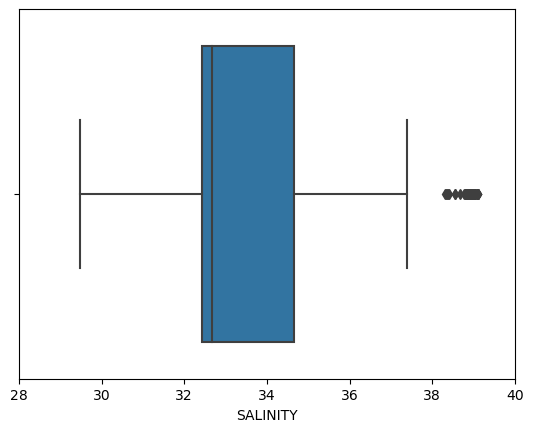

In [12]:
sal=sns.boxplot(data=merged_df, x="SALINITY")
sal.set_xlim(28, 40)
plt.show()

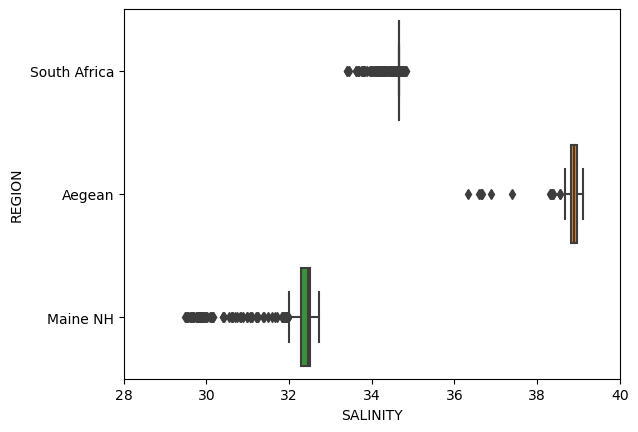

In [13]:

salreg=sns.boxplot(data=merged_df, x="SALINITY", y="REGION")
salreg.set_xlim(28, 40)
plt.show()

The overall boxplot distribution masks the clusters of the individual regions.

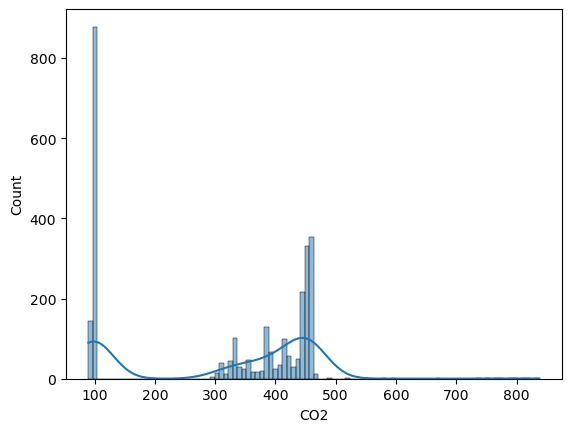

In [16]:
co2=sns.histplot(data=merged_df, x="CO2",bins=100,kde=True)
plt.show()

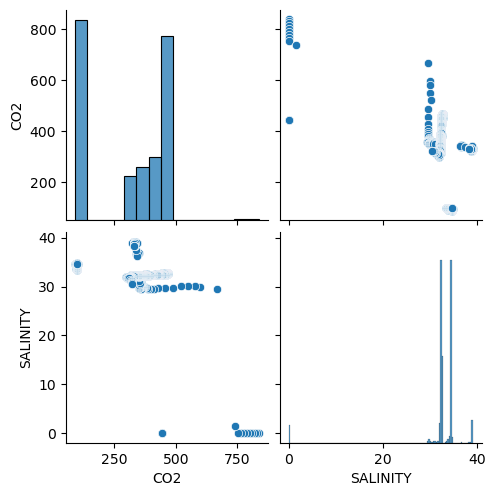

In [17]:
sns.pairplot(merged_df,vars=["CO2", "SALINITY"])
plt.show()

In [18]:
uppersal = merged_df['SALINITY'].mean()+merged_df['SALINITY'].std()
print(uppersal)
lowersal = merged_df['SALINITY'].mean()-merged_df['SALINITY'].mean().std()
print(lowersal)
merged_df['SALINITY'] = np.where(merged_df['SALINITY'] >uppersal,uppersal,np.where(merged_df['SALINITY'] < lowersal,
lowersal,merged_df['SALINITY']))
merged_df.describe()[['SALINITY']]


38.61710810325333
32.42658641556587


,SALINITY
count,2801.000000
mean,33.558146
std,1.504493
min,32.426586
25%,32.426586
50%,32.669000
75%,34.659750
max,38.617108


In [19]:
upperco2 = merged_df['CO2'].mean()+merged_df['CO2'].std()
print(upperco2)
lowerco2 = merged_df['CO2'].mean()-merged_df['CO2'].mean().std()
print(lowerco2)
merged_df['CO2'] = np.where(merged_df['CO2'] <upperco2,upperco2,np.where(merged_df['CO2'] > lowerco2,
lowerco2,merged_df['CO2']))
merged_df.describe()[['CO2']]

462.4652265221913
301.90242547536593


,CO2
count,2801.000000
mean,459.656381
std,21.053855
min,301.902425
25%,462.465227
50%,462.465227
75%,462.465227
max,462.465227


In [20]:
merged_df.count()

REGION       2801
Date_Time    2801
LATITUDE     2801
LONGITUDE    2801
SALINITY     2801
CO2          2801
dtype: int64

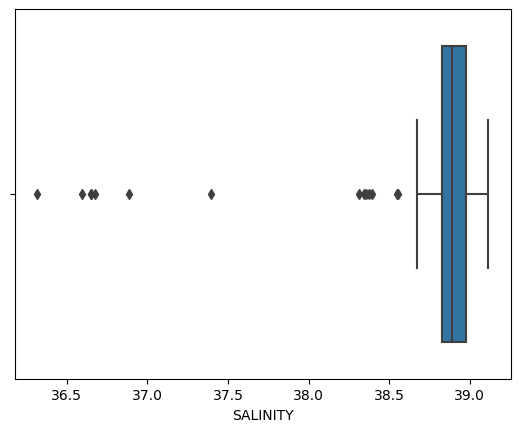

In [21]:
aegsal=sns.boxplot(data=AEG_df, x="SALINITY")
plt.show()

There are clearly outliers in the dataset.  Removing them is problematic, as the three regions have radically different distributions and need to be treated separately.  There are exceptions in the South Africa data, where some of the salinity readings were close to zero.  This set was problematic in general for several reasons.  There were cases where the dates needed to be removed due to ambiguities.

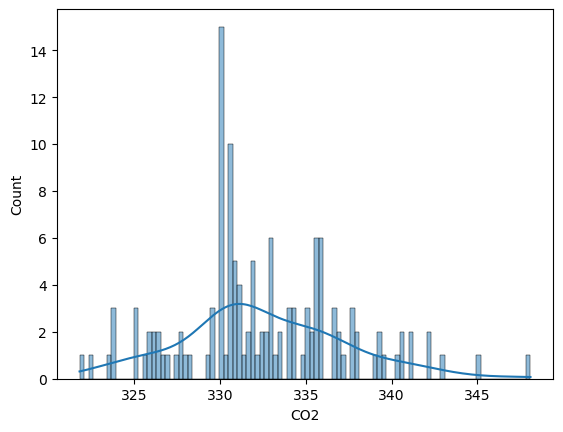

In [22]:
aegco2=sns.histplot(data=AEG_df, x="CO2",bins=100,kde=True)
plt.show()

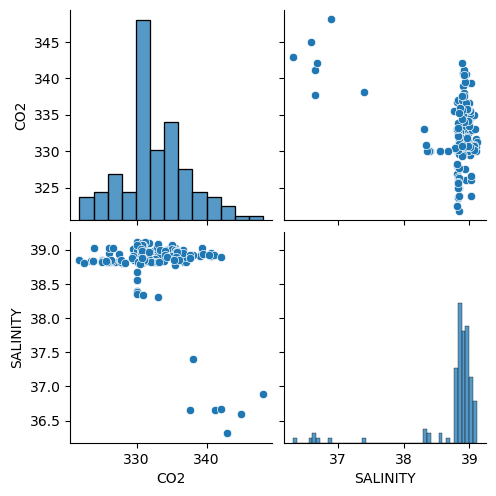

In [23]:
sns.pairplot(AEG_df,vars=["CO2", "SALINITY"])
plt.show()

The univariate relationships are somewhat more visible when an individual region is isolated as was done above.  The bivariate relationship is still difficult to discern without the removal of more data points.  

The South Africa data set has been problematic on several levels, so much so that it should be expurgated.  There are ambiguities with the dates; i.e. sometimes it was impossible to discern whether a date was December 6th or January 26th.  Some of the salinity measurements are clearly either measurement or entry errors.